In [1]:
%load_ext autoreload
%autoreload 2
from RTKToArrayConversion import *
from ExtendedConeBeamDCC import *
from TextFileSaving import * 
from AllAcquisitionCDClass import *
from ConeBeamDCCWithBackprojectionPlane import *
from tqdm import tqdm_notebook
%matplotlib notebook
import time

In [2]:
filesdir_ref = "/home/mmouchet/PycharmProjects/DccOnPhysicalDetectors/paper_dcc_simu_shrink/data/"
# reading projections
proj = itk.imread(filesdir_ref+"projections_thorax_4x360_920x1028_shrink10_a160.mha")
# Reading the geometry of the scanner
xmlreader = rtk.ThreeDCircularProjectionGeometryXMLFileReader.New()
xmlreader.SetFilename(filesdir_ref+'geometry_thorax_4x360_920x1028_a160.xml')
# xmlreader.SetFilename(filesdir_ref+"geometry.xml")
xmlreader.GenerateOutputInformation()
geometry = xmlreader.GetOutputObject()
print('nproj = %d'%(len(geometry.GetGantryAngles())))
print(proj.GetLargestPossibleRegion().GetSize())

nproj = 1440
itkSize3 ([920, 32, 1440])


In [3]:
# #shrinkage
# ImageType = itk.Image[itk.F,3]
# rebin = itk.BinShrinkImageFilter[ImageType,ImageType].New()
# rebin.SetInput(proj)
# rebin.SetShrinkFactor(0,1)
# rebin.Update()
# proj_rebin = rebin.GetOutput()
# print(proj_rebin.GetSpacing())


# # I0=0
# # dH2O=0.01879 #mm^-1 at 75 keV
# # if I0!=0:
# #     new_sino = I0*np.exp(-1.*dH2O*itk.GetArrayFromImage(proj_rebin))
# #     new_sino = np.maximum(np.random.poisson(new_sino), 1)
# #     new_sino = np.log(I0/new_sino)/dH2O
# #     proj_rebin_n = itk.GetImageFromArray(new_sino.astype(np.float32))
# #     proj_rebin_n.CopyInformation(proj_rebin)
# #     proj_rebin_n.Update()
# # #    itk.imwrite(proj,filesdir_ref + 'projections_thorax_360_shrink10_a170_noise.mha') 

#Convert to array for faster computation directly on the physical detector
geometry_array = RTKtoNP(geometry)
proj_array = itk.GetArrayFromImage(proj)
proj_infos = GetProjectionInformations(proj)
source_pos_array = GetSourcePositions(geometry)
rotation_matrices_array = GetRotationMatrices(geometry)
fixed_matrices_array = GetFixedSystemMatrices(geometry)
print(proj_infos)

AcquiDCC = DCCOnCDinAnAcquisition(geometry_array, source_pos_array, rotation_matrices_array, fixed_matrices_array, proj_array, proj_infos)

[array([1.028, 1.095, 1.   ]), array([-472.366 ,  -16.9725, -719.5   ]), array([ 920,   32, 1440]), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])]


In [4]:
# print(np.where(np.abs(geometry_array[8,:]+50) <=0.02))
# geometry_array[8,np.where(np.abs(geometry_array[8,:]+50) <=0.02)]
# plt.figure()
# plt.plot(geometry_array[2,:])
# plt.plot(1791,geometry_array[2, 1791],"*")
# plt.plot(1791-384,geometry_array[2, 1791-384],"*")
# plt.show()

<IPython.core.display.Javascript object>


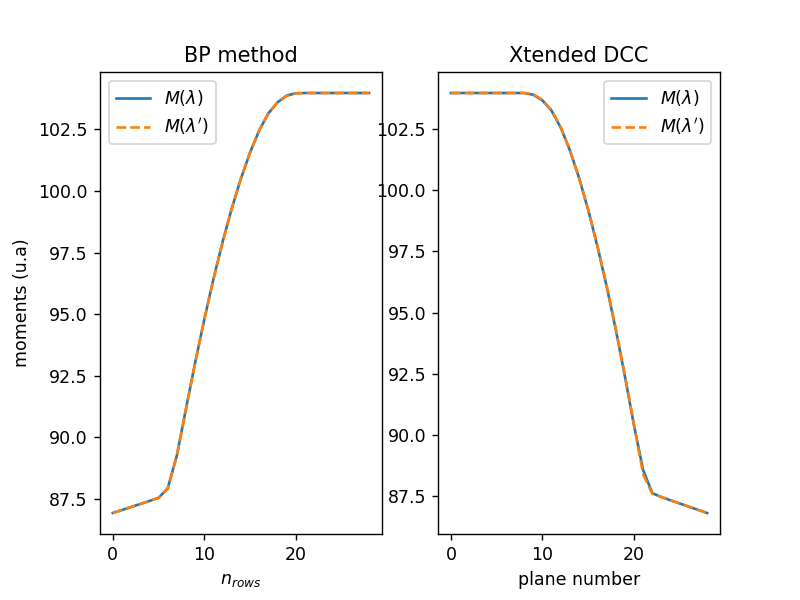

In [7]:
# Select the pair
idx0, idx1 = 720, 712
# print(geometry_array[:,idx0])
# print(geometry_array[:,idx1])
# Compute moments with backprojection plane
g0 = NPtoRTK(geometry_array, idx0)
g1 = NPtoRTK(geometry_array, idx1)
p0 = ARRAYtoRTK(proj_array, proj_infos[0], proj_infos[1], proj_infos[2], proj_infos[3], idx0)
p1 = ARRAYtoRTK(proj_array, proj_infos[0], proj_infos[1], proj_infos[2], proj_infos[3], idx1)
# itk.imwrite(p0,"/home/mmouchet/PycharmProjects/4D_study/bpm_12/neg0.mha")
# itk.imwrite(p1,"/home/mmouchet/PycharmProjects/4D_study/bpm_12/neg1.mha")
pair_bp = ProjectionsPairMpoints(idx0, idx1 , AcquiDCC.geometry, AcquiDCC.source_pos, AcquiDCC.mrot, AcquiDCC.fsm, AcquiDCC.projections, AcquiDCC.proj_infos, 0)
pair_bp.ComputeMPoints()
pair_bp.ComputeEpipolarPlanes()
pair_bp.ComputePairMoments()
# pair_bp.LinesMomentsCorners()
# print(np.sum(np.abs(pair_bp.m0 - pair_bp.m1)/pair_bp.m0)/len(pair_bp.m0))

pair = ProjectionsPairBeta(idx0, idx1 , AcquiDCC.geometry, AcquiDCC.source_pos, AcquiDCC.mrot, AcquiDCC.fsm, AcquiDCC.projections, AcquiDCC.proj_infos, 0)
pair.ComputeEpipolarPlanes()
# pair.ComputeBetaRange()
pair.ComputePairMoments()
# pair.PlotPairMoments()
# print(np.sum(np.abs(pair.m0 - pair.m1)/np.sqrt(pair.var0))/len(pair.m0))

plt.figure()
plt.subplot(121)
plt.plot(pair_bp.m0, label=r"$M(\lambda)$")
plt.plot(pair_bp.m1, '--', label=r"$M(\lambda')$")
# # # plt.ylim(90.5,93.5)
plt.ylabel(r"moments (u.a)")
plt.xlabel(r"$n_{rows}$")
plt.legend()
plt.title("BP method")
plt.subplot(122)
plt.plot(pair.m0, label=r"$M(\lambda)$")
plt.plot(pair.m1,'--', label=r"$M(\lambda')$")
plt.legend()
plt.xlabel("plane number")
plt.title("Xtended DCC")
# plt.ylim(90.5,93.5)
# plt.yticks([])
plt.show()

In [ ]:
# print(pair.eb[0]/np.sqrt(pair.eb[0]**2+pair.eb[2]**2), -np.sign(pair.gamma_s0)*np.sin(pair.g0[2]-pair.gamma_s0))
# print(pair.eb[2]/np.sqrt(pair.eb[0]**2+pair.eb[2]**2), -np.sign(pair.gamma_s0)*np.cos(pair.g0[2]-pair.gamma_s0))
# print(pair.eb[0]/np.sqrt(pair.eb[0]**2+pair.eb[2]**2), -np.sign(pair.gamma_s1)*np.sin(pair.g1[2]-pair.gamma_s1))
# print(pair.eb[2]/np.sqrt(pair.eb[0]**2+pair.eb[2]**2), -np.sign(pair.gamma_s1)*np.cos(pair.g1[2]-pair.gamma_s1))
# print(pair_bp.eb0[0]/np.sqrt(pair_bp.eb0[0]**2+pair_bp.eb0[2]**2), np.sign(pair_bp.gamma_s0)*np.sin(pair_bp.gamma_s0))
# print(pair_bp.eb0[2]/np.sqrt(pair_bp.eb0[0]**2+pair_bp.eb0[2]**2), -np.sign(pair_bp.gamma_s0)*np.cos(pair_bp.gamma_s0))
# print(pair_bp.eb1[0]/np.sqrt(pair_bp.eb1[0]**2+pair_bp.eb1[2]**2), np.sign(pair_bp.gamma_s1)*np.sin(pair_bp.gamma_s1))
# print(pair_bp.eb1[2]/np.sqrt(pair_bp.eb1[0]**2+pair_bp.eb1[2]**2), -np.sign(pair_bp.gamma_s1)*np.cos(pair_bp.gamma_s1))

In [ ]:
from WeLovePlots import *
PlotPairGeometry2(pair_bp)
PlotPairGeometry2Bis(pair)

In [ ]:
# plt.figure()
# plt.subplot(121)
# plt.plot(pair.I20)
# plt.plot(pair.I21,'--')
# plt.subplot(122)
# plt.plot(pair.I10)
# plt.plot(pair.I11,'--')
# # plt.subplot(133)
# # plt.plot(pair.w0[:, 0])
# # plt.plot(pair.sdd/np.sqrt(pair.sdd**2+pair.v0[:,0]**2),'--')
# # # plt.plot(pair.w1[:, 0])
# # # plt.plot(np.sign(pair.B_gamma1[:,0])*pair.sdd/np.sqrt(pair.sdd**2+pair.v1[:,0]**2),'--')
# plt.show()


In [ ]:
# plt.figure()
# plt.subplot(121)
# plt.plot(pair.gamma0, pair.coeffs0)
# ax = plt.twinx()
# ax.plot(pair.gamma0, np.sum(pair.proj_interp0, axis=1),'r')
# plt.subplot(122)
# plt.plot(pair.gamma1, pair.coeffs1)
# ax = plt.twinx()
# ax.plot(pair.gamma1, np.sum(pair.proj_interp1, axis=1),'r')
# plt.show()